# Amne Data Science Technical Assignment

- Author: Jay Shah [@jayshah5696](https://github.com/jayshah5696)
- Date: 03/25/2019
- Description: Property Valuation model.

----------

## Overview

- **Introduction / Abstract**
- **Load libraries & get data**
    - Split data to training and test set
        - stratified sampling based on certain feature(s) or label(s)
- **Exploratory Data Analysis**
    - Discover and visualize the training data to gain insights
- **Data Preprocessing**
    - Prepare data for ML algorithms
    - Write pipelines using transformers to do automated feature engineering:
        - Data scaling
        - Impute missing data (or remove)
        - Feature extraction
            - Create new dimensions by combining existing ones
        - Feature selection
            - Choose subset of features from the existing features
- **Model Selection & Training**
    - Use K-Folds Cross-Validation to select top 2 to 5 most promising models
        - Do not spend too much time tweaking hyperparameters
    - Typical ML models include kNN, SVM, linear/logistic regression, ensemble methods (RF, XGB), neural networks, etc.
    - [Optional] Save experimental models to pickle file.
- **Model Tuning**
    - `GridSearchCV`, `RandomSearchCV`, or `BayesSearchCV`
        - `GridSearchCV`: brute force way to search for 'best' hyperparameters
        - `BayesSearchCV`: smart way to use Bayesian inference to optimally search for best hyperparameters
- **Model Evaluation**
    - Final evaluation on hold out test set
    - If regression, calculate 95% confidence interval range
        - t score or z score to calculate confidence interval
- **Solution Presentation and/or submission**
    - What I learned, what worked & what did not, what assumptions were made, and what system's limitations are
    - Create clear visualizations & easy-to-remember statements
- **Deployment**
    - Clean up and concatenate pipleines to single pipeline to do full data preparation plus final prediction
    - Create programs to monitor & check system's live performance    

## Introduction / Abstract

As a real estate technology company, Amne continuously works on
improving our automated valuation models (AVMs). These are used to help determine how
much we should offer for any given property or at what price we should list our own inventory.
You’ve been assigned the project of designing a new AVM to predict the estimated price at
which a given property will sell.

## Load libraries & data

- Load important libraries
- Load (or acquire) associated data


In [488]:
__author__ = 'Jay Shah(https://www.github.com/jayshah5696)' 

# Version check
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

# linear algebra
import numpy as np 

# data processing
import pandas as pd 

# data visualization
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
sns.set(style='white', context='notebook', palette='deep')
print('Data Manipulation, Mathematical Computation and Visualisation packages imported!')
# Set visualisation colours
#mycols = ["#66c2ff", "#5cd6d6", "#00cc99", "#85e085", "#ffd966", "#ffb366", "#ffb3b3", "#dab3ff", "#c2c2d6"]
#sns.set_palette(palette = mycols, n_colors = 4)
print('My colours are ready! :)')

# Algorithms
from sklearn.linear_model import SGDClassifier, LogisticRegression, Perceptron,LinearRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import xgboost as xgb
import lightgbm as lgb

# Preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder

# Pipeline
from sklearn.pipeline import Pipeline

# Manifold Learning
from sklearn.manifold import LocallyLinearEmbedding, TSNE

# Feature Selection
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectPercentile, chi2, RFECV

# Metrics 
from sklearn.metrics import log_loss, f1_score, accuracy_score
from sklearn.model_selection import cross_val_score

# Model Selection & Hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from skopt import BayesSearchCV
from skopt.space  import Real, Categorical, Integer

# Decomposition
from sklearn.decomposition import PCA

# Discriminant Analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Clustering
from sklearn.cluster import KMeans

# Mathematical Functions
import math

# Utils
from collections import Counter


# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import missingno as msno

# Statistical packages used for transformations
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats.stats import pearsonr

import gc

The scikit-learn version is 0.20.0.
Data Manipulation, Mathematical Computation and Visualisation packages imported!
My colours are ready! :)


# Initial Data Understanding

In [257]:
df = pd.read_csv('../data/raw/amne_ds_onsite_dataset.csv')

In [255]:
df.head()

,Unnamed: 0,mls,matrix_id,mls_number,parcel_number,address,unit_number,city,county,zipcode,lat,long,property_subtype,subdiv_name,baths_full,baths_half,baths_total,beds_total,sqft_total,lot_size_acres,n_stories,year_built,num_living,num_main_lvl_beds,num_other_lvl_beds,num_dining_area,num_fireplaces,spa_hottub_yn,sprinkler_yn,rooms,pool_on_prop,water_source,fema_100yr_flood,hoa_yn,hoa_fee_freq,status,close_price,agent_mls_id,agent_full_name,photo_count,tax_amount,tax_year,cdom,auction_yn,close_date,num_parking_spaces,close_year,which_floor,avg_close_price_by_city_x,list_count_by_city_x,avg_close_price_by_city_y,list_count_by_city_y
0,0,actris,407367,363606,01681104080000,8711 Crest Ridge Cir,NaN,Austin,Travis,78750.0,30.43546,-97.78609,House,BALCONES VILLAGE,2.0,NaN,2.0,4.0,2313.0,NaN,1,1976.0,2.0,0.0,0.0,NaN,1.0,NaN,NaN,NaN,False,['City'],No,0,NaN,Sold,146664.08856,316968.0,Roger Hill,1.0,2762.0,1994.0,170.0,NaN,1996-05-17,NaN,1996,1,237779.662761,51829.0,237779.662761,51829.0
1,1,actris,408400,376227,01641301030000,10605 Tweedsmuir Dr,NaN,Austin,Travis,78750.0,30.42698,-97.79538,House,PARK AT SPICEWOOD SPRINGS PH,2.0,1.0,3.0,4.0,2416.0,NaN,2,1984.0,1.0,0.0,0.0,NaN,1.0,NaN,NaN,NaN,False,['City'],No,0,NaN,Sold,165395.37048,430361.0,Mary Dix,1.0,4442.0,1995.0,82.0,NaN,1996-06-21,NaN,1996,1,237779.662761,51829.0,237779.662761,51829.0
2,2,actris,409486,383227,01701309150000,9422 Spring Hollow Dr,NaN,Austin,Travis,78750.0,30.44019,-97.79796,House,BALCONES VILLAGE SEC 6,2.0,1.0,3.0,4.0,0.0,NaN,1,1977.0,3.0,0.0,0.0,NaN,1.0,NaN,NaN,['Game'],False,['City'],No,0,NaN,Sold,158947.50615,437887.0,Erma Christopher,1.0,3901.0,1995.0,24.0,NaN,1996-06-21,NaN,1996,1,237779.662761,51829.0,237779.662761,51829.0
3,3,actris,409485,383212,163970000B0006,12106 Grey Rock Ln,NaN,Austin,Williamson,78750.0,30.45678,-97.81006,House,GREY ROCK VILLAGE AT ANDERSO,2.0,NaN,2.0,3.0,1668.0,NaN,1,1977.0,2.0,0.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,['MUD'],No,0,NaN,Sold,83767.47960,255263.0,Frederick Sims,1.0,2347.0,1995.0,24.0,NaN,1996-06-21,NaN,1996,1,237779.662761,51829.0,237779.662761,51829.0
4,4,actris,407945,372634,01661317070000,9009 Westerkirk Dr,NaN,Austin,Travis,78750.0,30.43006,-97.79292,House,PARK AT SPICEWOOD SPRINGS PH,3.0,1.0,4.0,5.0,3644.0,NaN,2,1990.0,3.0,0.0,0.0,NaN,1.0,NaN,NaN,['Game'],False,['MUD'],No,0,NaN,Sold,263160.84435,420040.0,Sara Michael,1.0,6700.0,1995.0,112.0,NaN,1996-06-21,NaN,1996,1,237779.662761,51829.0,237779.662761,51829.0


In [8]:
df.shape

(100000, 46)

In [9]:
np.array(df.columns)

array(['Unnamed: 0', 'mls', 'matrix_id', 'mls_number', 'parcel_number',
       'address', 'unit_number', 'city', 'county', 'zipcode', 'lat',
       'long', 'property_subtype', 'subdiv_name', 'baths_full',
       'baths_half', 'baths_total', 'beds_total', 'sqft_total',
       'lot_size_acres', 'n_stories', 'year_built', 'num_living',
       'num_main_lvl_beds', 'num_other_lvl_beds', 'num_dining_area',
       'num_fireplaces', 'spa_hottub_yn', 'sprinkler_yn', 'rooms',
       'pool_on_prop', 'water_source', 'fema_100yr_flood', 'hoa_yn',
       'hoa_fee_freq', 'status', 'close_price', 'agent_mls_id',
       'agent_full_name', 'photo_count', 'tax_amount', 'tax_year', 'cdom',
       'auction_yn', 'close_date', 'num_parking_spaces'], dtype=object)

In [13]:
df.describe(include='all')

,Unnamed: 0,mls,matrix_id,mls_number,parcel_number,address,unit_number,city,county,zipcode,lat,long,property_subtype,subdiv_name,baths_full,baths_half,baths_total,beds_total,sqft_total,lot_size_acres,n_stories,year_built,num_living,num_main_lvl_beds,num_other_lvl_beds,num_dining_area,num_fireplaces,spa_hottub_yn,sprinkler_yn,rooms,pool_on_prop,water_source,fema_100yr_flood,hoa_yn,hoa_fee_freq,status,close_price,agent_mls_id,agent_full_name,photo_count,tax_amount,tax_year,cdom,auction_yn,close_date,num_parking_spaces
count,100000.000000,100000,100000.000000,1.000000e+05,99993,100000,893,99941,100000,99999.000000,99630.000000,99630.000000,99865,99926,100000.000000,96982.000000,100000.000000,100000.000000,99999.000000,68961.000000,100000,99937.000000,100000.000000,100000.000000,100000.000000,32947.000000,99426.000000,3970,0.0,66408,98919,98665,100000,100000,40361,100000,1.000000e+05,92757.000000,92757,100000.000000,93102.000000,99923.000000,100000.000000,0.0,100000,0.0
unique,NaN,1,NaN,NaN,86907,85410,218,121,14,NaN,NaN,NaN,4,18940,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,5914,2,25,5,2,3,1,NaN,NaN,5009,NaN,NaN,NaN,NaN,NaN,3808,NaN
top,NaN,actris,NaN,NaN,no pid,2100 Pipers Field Dr,N,Austin,Travis,NaN,NaN,NaN,House,VILLAGE AT WESTERN OAKS SEC,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,['Utility'],False,['City'],No,False,Annually,Sold,NaN,NaN,Tom Ibarra,NaN,NaN,NaN,NaN,NaN,2006-06-30 00:00:00,NaN
freq,NaN,100000,NaN,NaN,10,26,104,51829,58238,NaN,NaN,NaN,97038,502,NaN,NaN,NaN,NaN,NaN,NaN,67767,NaN,NaN,NaN,NaN,NaN,NaN,3970,NaN,5753,91582,71569,86715,80007,20400,100000,NaN,NaN,3350,NaN,NaN,NaN,NaN,NaN,190,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1996-05-16 00:00:00,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-07-20 00:00:00,NaN
mean,49999.500000,NaN,547171.851470,2.141641e+06,NaN,NaN,NaN,NaN,NaN,78679.387154,30.366407,-97.764235,NaN,NaN,2.120860,0.313007,2.424420,3.308340,1602.413134,0.756850,NaN,1986.145081,1.598960,2.287400,0.884620,1.485598,0.818377,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.058654e+05,369522.551268,NaN,2.761330,3693.500601,2001.865216,73.235070,NaN,NaN,NaN
std,28867.657797,NaN,109619.187126,2.736607e+06,NaN,NaN,NaN,NaN,NaN,659.270388,0.180469,0.168018,NaN,NaN,0.637289,0.483424,0.866842,0.746935,1091.717359,9.380767,NaN,17.977164,0.781699,1.305419,1.452153,0.536415,0.523852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.899391e+05,101085.897750,NaN,2.991213,7543.821334,84.159555,93.606318,NaN,NaN,NaN
min,0.000000,NaN,282018.000000,2.784820e+05,NaN,NaN,NaN,NaN,NaN,0.000000,28.004480,-116.765780,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,-0.500000,NaN,1830.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.157125e+03,11965.000000,NaN,0.000000,1.000000,0.000000,0.000000,NaN,NaN,NaN
25%,24999.750000,NaN,454178.500000,5.144718e+05,NaN,NaN,NaN,NaN,NaN,78641.000000,30.233290,-97.847420,NaN,NaN,2.000000,0.000000,2.000000,3.000000,1064.000000,0.000000,NaN,1979.000000,1.000000,1.000000,0.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.155582e+05,304320.000000,NaN,1.000000,1816.250000,1998.000000,14.000000,NaN,NaN,NaN


In [258]:
# Converting column into timestamp column
timestamp_columns = ['close_date']
for col in timestamp_columns:
    df[col] = pd.to_datetime(df[col])

In [259]:
drop_columns_list=[]
drop_columns_list.append('sprinkler_yn')
drop_columns_list.append('auction_yn')
drop_columns_list.append('num_parking_spaces')
drop_columns_list.append('Unnamed: 0')

# Data Description

By looking at purely description of data:
- Data is from only one MLS - Actris
- Mostly properties are from Austin City (51829)
- Travis county is most popular county(58238). I assume it is part of Austin.
- Zip code & year build Range has lot of incorrect entries(0)
- Sprinkler_yn has no data entries(all NaN)
- Cdom distribution has wide tail
- Auction_yn has no data entries(all NaN)
- Num_parking_spaces has no data entries (all NaN)
- Target varibale is close_price
- status has only one value

Removed columns:
- sprinkler_yn
- auction_yn
- num_parking_spaces
- Unnamed: 0

In [260]:
print('data dimensions before dropping the columns: ',df.shape)
for col in df.columns:
    if col in drop_columns_list:
        df.drop(col,axis=1,inplace=True)
print('data dimensions after dropping the columns: ',df.shape)

data dimensions before dropping the columns:  (100000, 46)
data dimensions after dropping the columns:  (100000, 42)


## Exploratory Data Analysis (EDA)

- Visualize training data using different kinds of plots
- Plot dependent variables (features) against independent variable (target label)

In [17]:
dtype_df = df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,bool,1
1,int64,2
2,float64,21
3,datetime64[ns],1
4,object,17


### Dealing with columns by column type

In [18]:
num_features = df.columns[(df.dtypes =='float64')]
int_features = df.columns[(df.dtypes =='int64' )]
cat_features =df.columns[df.dtypes == 'object']
bool_features= df.columns[df.dtypes == 'bool']
ts_features= df.columns[df.dtypes == 'datetime64[ns]']

#### Understanding the target variable

Minimum Close Price 6157.12464
Median Close Price 155609.15315819997
Maximum Close Price 7430956.95


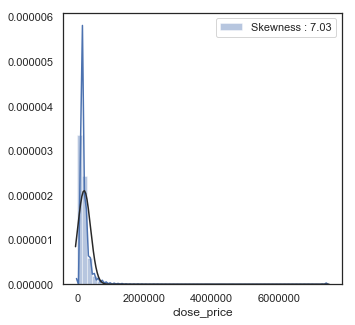

In [40]:
plt.subplots(figsize=(5,5))
g = sns.distplot(df['close_price'], fit=norm, label = "Skewness : %.2f"%(df['close_price'].skew()));
g = g.legend(loc="best")
print('Minimum Close Price',df['close_price'].min())
print('Median Close Price',df['close_price'].median())
print('Maximum Close Price',df['close_price'].max())

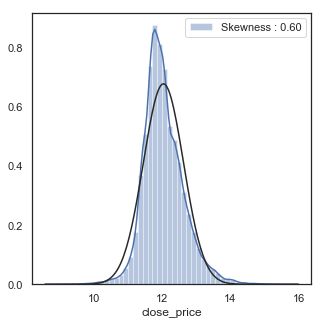

In [38]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
#train["SalePrice"] = np.log1p(train["SalePrice"])
#y_train = train["SalePrice"]

#Check the new distribution 
plt.subplots(figsize=(5, 5))
g = sns.distplot( np.log1p(df["close_price"]), fit=norm, label = "Skewness : %.2f"%( np.log1p(df["close_price"]).skew()));
g = g.legend(loc="best")

we will convert this target variable before the modeling, now we can leave at it is

#### Boolean columns

hoa_yn - if house is part of home owner association? yes or no

In [25]:

print(bool_features)
df[bool_features[0]].value_counts()


Index(['hoa_yn'], dtype='object')


False    80007
True     19993
Name: hoa_yn, dtype: int64

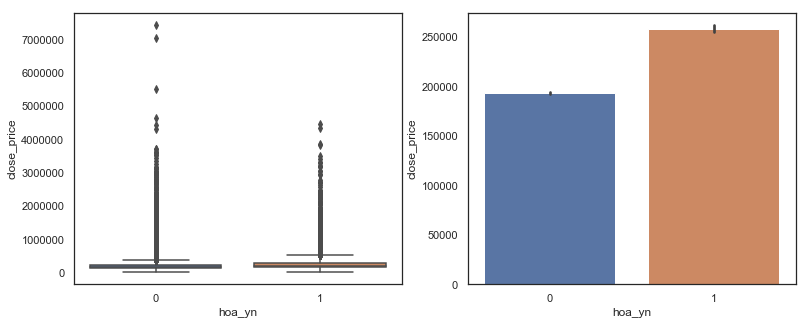

In [42]:
def bool_plot(data,column,ycolumn):
    # plotting against the y column to understand the relationship 
    # with output variable
    data[column] = np.array(data[column],dtype='int64')
    plt.subplots(figsize =(20, 5))
    # Box plot to understand the distribution
    plt.subplot(1, 3, 1)
    sns.boxplot(x=column, y=ycolumn, data=data);
    # swarm plot to understand the distribution
    #plt.subplot(1, 3, 2)
    #sns.swarmplot(x=column, y=ycolumn, data=data, size = 5);
    # Bar plot to understand the mean value in each class
    plt.subplot(1, 3, 2)
    sns.barplot(x=column, y=ycolumn, data=data)
    plt.show();

bool_plot(df,column=bool_features[0],ycolumn='close_price')

- It looks like mean price of the house is slightly higher for houses associated with hoa
- for model understanding converting boolean feature into 0,1 feature for False and True Category

In [261]:
df[bool_features[0]] = np.array(df[bool_features[0]],dtype='int64')

### Dealing with integer and object based columns

In [82]:
def cat_plot(data,column,ycolumn):
    # plotting against the y column to understand the relationship 
    # with output variable
    
    plt.subplots(figsize =(20, 5))
    # Box plot to understand the distribution
    plt.subplot(1, 3, 1)
    sns.boxplot(x=column, y=ycolumn, data=data);
    # swarm plot to understand the distribution
    #plt.subplot(1, 3, 2)
    #sns.swarmplot(x=column, y=ycolumn, data=data, size = 5);
    # Bar plot to understand the mean value in each class
    plt.subplot(1, 3, 2)
    sns.barplot(x=column, y=ycolumn, data=data)
    plt.show();

def numerical_plot(data,column,ycolumn):
    #fig,ax = plt.subplots(1,figsize=(8,8))
    sns.jointplot(x=column, y=ycolumn, data=data, size=6, kind='scatter', color='#800000', space=0,label='%2f'%pearsonr(data[column], data[ycolumn])[0])
    print('Correlation:',pearsonr(data[column], data[ycolumn])[0])
    #ax.set_ylabel(ycolumn)
    plt.show()

matrix_id


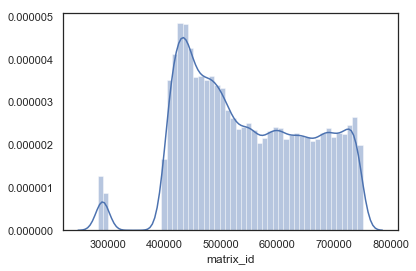

In [262]:
feat = int_features[0]
print(feat)
sns.distplot(df[feat]);

Correlation: 0.11542604465275264


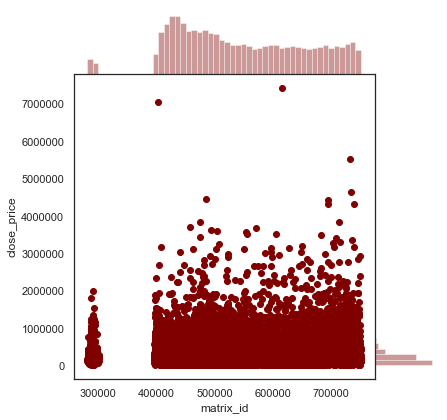

In [87]:
numerical_plot(df,feat,ycolumn='close_price')

Matrix Id is associated with each house. 
- As we know this data is from only one listing, thn we know matrix id for each house in unique
- We can list each houses by feature calculated from this feature that tells about number of past sales
- Also, Avg past selling price
- Looks like we dont have unique matrix id for each house rathe for each listing.
- We can drop this, as we don't know about it associaltion
- Wide gap in Matrix id between 300000, and 400000

gap is in data?

In [231]:
#df['close_date'].dt.year

Correlation: 0.6575998383116618


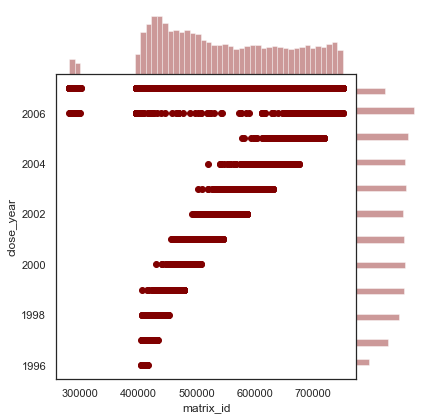

In [263]:
df['close_year'] = df['close_date'].dt.year
numerical_plot(df,feat,ycolumn='close_year')

In [109]:

#numerical_plot(df,feat,ycolumn='zipcode')

In [110]:
temp = df.copy()
temp["is_duplicate"]= temp[feat].duplicated()
temp['is_duplicate'].value_counts()

False    100000
Name: is_duplicate, dtype: int64

In [111]:
from itertools import accumulate
def cumsum_bounded(z, upper_bound = 500000, lower_bound = 0):
    return list(accumulate(z, lambda x,y:min(upper_bound,max(lower_bound,x+y))))

In [112]:
temp = df.copy()
temp['sell_count'] = 1
temp.sort_values(by='close_date',inplace=True)


In [114]:
#temp = temp.groupby(by=[feat])['sell_count'].agg(cumsum_bounded).reset_index()

mls_number


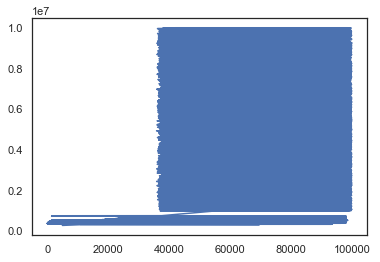

In [97]:
feat = int_features[1]
print(feat)
plt.plot(df[feat].sort_values());

In [98]:
temp = df.copy()
temp["is_duplicate"]= temp[feat].duplicated()
temp['is_duplicate'].value_counts()

False    100000
Name: is_duplicate, dtype: int64

In [236]:
feat = cat_features[1]
print(feat)
#cat_plot(df,column=feat,ycolumn='close_price')

parcel_number


In [137]:
# Removing no pid number and matching that from same house by matrix id
no_pid_df = df[[feat,'address']][df[feat]=='no pid']
temp = df[[feat,'address']][(df['address'].isin(no_pid_df['address'].values))]


In [140]:
match_add = temp[temp[feat] != 'no pid']

,parcel_number,address
26882,1130570000014001,15515 Fox Run Dr
30553,1130570000016004,15605 Fox Run Dr
38078,05940010000143000,113 Sunfire
48811,1130570000014004,15515 Fox Run Dr
95147,17W339383F00230004,505 W South St


The number is uique for each house and owner. I think we can not impute this
dropping this column

In [237]:
drop_columns_list.append('mls')
drop_columns_list.append(feat)

In [248]:
feat = cat_features[2]
print(feat)


address


we can see which houses in the past sold for which price and how many times

In [249]:
temp = df.copy()
temp.dropna(subset=['address'],inplace=True)
temp['sell_count'] = 1
temp.sort_values(by=[feat,'close_date'],inplace=True)
temp2 = temp.groupby(by=[feat])['sell_count'].agg(cumsum_bounded).reset_index()

In [250]:
temp2['sell_count'].apply(lambda x: x[-1]).unique()

array([ 1,  2,  3,  4, 14,  6,  5,  7,  8, 26, 16, 10, 12,  9],
      dtype=int64)

In [251]:
temp2.head()

,address,sell_count
0,Briar St,[1]
1,#7 Harbor Dr,[1]
2,#8 Townhouse Cir,[1]
3,0 #346,[1]
4,0 -711 East 9 1/2 St,[1]


In [252]:
df_temp = pd.DataFrame()
for i,add in enumerate(temp2['address'].unique()):
    temp= df[(df['address']==add)]
    temp.sort_values(by=[feat,'close_date'],inplace=True)
    temp['sell_count']= temp2['sell_count'][i]
    df_temp = pd.concat([df_temp,temp])
temp.to_csv('../data/processed/processed_df.csv',index=None)

KeyboardInterrupt: 

In [265]:
feat = cat_features[3]
print(feat)


unit_number


In [177]:
df[feat].unique()

array([nan, '46', '1', 'B', 'N', 'S', 'DRIV', 'C', 'A', '323B', '174',
       '7202', '111', '44H', '15', 'DR', '13', 'AB', '910', '2', '103',
       '45', '9', '4', '108', '961', '100', '2129', '12', '264', 'G',
       '10', '55', '418', '133', 'LANE', 'K2', '32', '903', '1806', '41',
       'I', '6', '5007', '3', '61', '235', '156', '150', '109', '121',
       '1219', '5', '210', '113', '123', '104', '#', '2503', '48', '7',
       'D', 'Y', '110', 'VILL', '107', '7402', 'D1', '170', '7158', '23',
       '10A', '1120', 'LOOP', '243', '136', '30', '11', '27', 'E', '410',
       '553', 'RES', '33', 'O', '8', '102', '412', 'H', 'FULL', 'C300',
       '`', '16', 'J', '51', '2B', '6831', '422', '93', '116', '29', '19',
       '37', '129', 'P', '28', 'GLEN', 'RUST', '17', '64', '24', '58',
       '39', '68', '7154', '140I', '54', '63', '52', '224E', '148', '31',
       '36', '43', '2020', '49', '57', '40', '14', '47', '59', 'K1',
       '7875', '147', '165', '166', '83', '242', '106', '6803

In [266]:
def which_floor(x):
    if (x != x):
        return 1
    else:
        if len(x)==3:
            ret_x = x[0]
        elif len(x)==4:
            ret_x = x[:2]
        else:
            ret_x = 1
    
    try:
        ret_x = int(ret_x)
        return  ret_x
    except:
        return 1
df['which_floor'] = df[feat].apply(lambda x:which_floor(x))

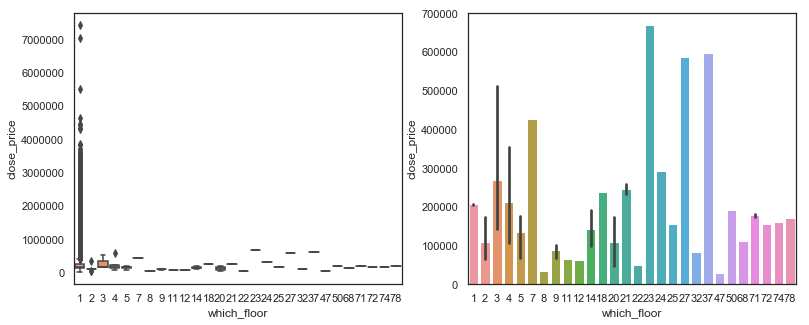

In [536]:
#df['which_floor'].value_counts()
cat_plot(df,column='which_floor',ycolumn='close_price')

In [267]:
feat = cat_features[4]
print(feat)
df[feat].unique()

city


array(['Austin', 'Cedar Park', 'Pflugerville', 'Del Valle', nan,
       'Bastrop', 'Lago Vista', 'Manchaca', 'Wimberley', 'Florence',
       'Kyle', 'The Hills', 'Lakeway', 'Mountain City',
       'Dripping Springs', 'West Lake Hills', 'Elgin', 'Smithville',
       'San Marcos', 'Buda', 'Hutto', 'Woodcreek', 'Liberty Hill',
       'Cedar Creek', 'Paige', 'Spicewood', 'Manor', 'Andice',
       'Rollingwood', 'Leander', 'Jonestown', 'Thorndale', 'Round Rock',
       'Briarcliff', 'Granger', 'Jarrell', 'Johnson City', 'Bee Cave',
       'Georgetown', 'Rosanky', 'Rockdale', 'Lexington', 'Luling',
       'Thrall', 'Marble Falls', 'Red Rock', 'Salado', 'Burnet',
       'Driftwood', 'Sunrise Beach', 'Bertram', 'Mustang Ridge',
       'Niederwald', 'Taylor', 'Briggs', 'Meadowlakes', 'Granite Shoals',
       'Volente', 'Dale', 'Lockhart', 'Horseshoe Bay', 'McDade',
       'Buchanan Dam', 'Harwood', 'Maxwell', 'Blanco', 'Hays',
       'Watterson', 'Coupland', 'Bartlett', 'Giddings', 'Point Ventu

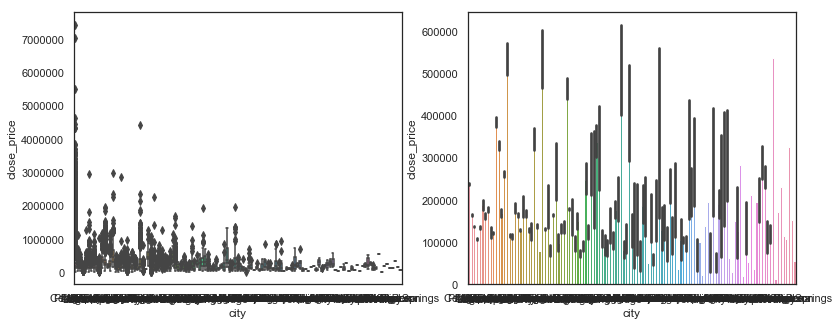

In [189]:
cat_plot(df,column=feat,ycolumn='close_price')

Mean Price for listing is all different. We can use that as a feature

In [268]:
temp = df.groupby(by=feat)['close_price'].mean().reset_index()
temp.rename(columns={'close_price':'avg_close_price_by_city'},inplace=True)
temp['list_count_by_city'] = df.groupby(by=feat)['close_price'].count().values
df = pd.merge(df,temp,how='left',on='city')

In [269]:
feat = cat_features[5]
print(feat)
df[feat].unique()

county


array(['Travis', 'Williamson', 'Hays', 'Bastrop', 'Burnet', 'Blanco',
       'Other', 'Caldwell', 'Lee', 'Fayette', 'Llano', 'Milam',
       'Gillespie', 'Comal'], dtype=object)

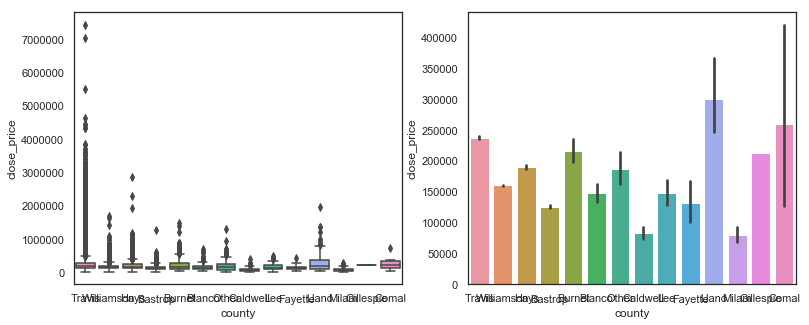

In [196]:
cat_plot(df,column=feat,ycolumn='close_price')

In [270]:
temp = df.groupby(by=feat)['close_price'].mean().reset_index()
temp.rename(columns={'close_price':'avg_close_price_by_county'},inplace=True)
temp['list_count_by_county'] = df.groupby(by=feat)['close_price'].count().values
df = pd.merge(df,temp,how='left',on='county')

In [271]:
feat = cat_features[6]
print(feat)
df[feat].unique()

property_subtype


array(['House', 'Townhouse', 'Mobile Home', nan, 'Manufactured'],
      dtype=object)

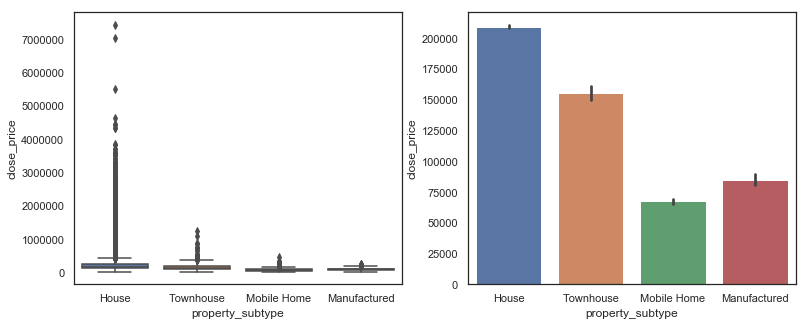

In [272]:
cat_plot(df,column=feat,ycolumn='close_price')

In [369]:
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier
from sklearn.preprocessing import Imputer
class KNNImputer_reg:
    def __init__(self,k=10):
        self.regressors = {}
        self.k = k
    def fit(self,df, col,input_columns):
        # Using only continuous values to find out the missing value
        # In future we can add the variable for the modeling aproch
        input_features = input_columns
        # Using Only column that does not having missing value is used for our modeling approch
        #input_features = np.array(input_features)[(df[input_features].isna().sum()*100/df.shape[0]) ==0]
        
        output_features = col
        
        regressor = KNeighborsRegressor(self.k)
        
        train = df[~(df[output_features].isna())]
        train = train.dropna(subset=input_features)
        regressor.fit(train[input_features],train[output_features])
        
        self.regressor = regressor
        self.input_features = input_features
        self.output_features = output_features
        return self

    def transform(self, df):
        
        # For transforming we can use the direct saved regressor
        # on missing value points
        
        test = df[df[self.output_features].isna()]
        x = test[self.input_features]
        regressor = self.regressor
        y = regressor.predict(x)
        df.loc[df[self.output_features].isna(),self.output_features]=y
        return df[self.output_features]
    
class KNNImputer_class:
    def __init__(self,k=10):
        self.regressors = {}
        self.k = k
    def fit(self,df, col,input_columns):
        # Using only continuous values to find out the missing value
        # In future we can add the variable for the modeling aproch
        input_features = input_columns
        # Using Only column that does not having missing value is used for our modeling approch
        #input_features = np.array(input_features)[(df[input_features].isna().sum()*100/df.shape[0]) ==0]
        output_features = col
        
        regressor = KNeighborsClassifier(self.k)
        
        train = df[~(df[output_features].isna())]
        train = train.dropna(subset=input_features)
        regressor.fit(train[input_features],train[output_features])
        
        self.regressor = regressor
        self.input_features = input_features
        self.output_features = output_features
        return self

    def transform(self, df):
        
        # For transforming we can use the direct saved regressor
        # on missing value points
        
        test = df[df[self.output_features].isna()]
        x = test[self.input_features]
        regressor = self.regressor
        y = regressor.predict(x)
        df.loc[df[self.output_features].isna(),self.output_features]=y
        return df[self.output_features]

imputing_with_knn_based on close_price,num_living,num_main_lvl_beds,num_other_lvl_beds

In [274]:
knn_property_subtype = KNNImputer_class()
input_columns = ['close_price','num_living','num_main_lvl_beds','num_other_lvl_beds']
knn_property_subtype.fit(df.copy(),feat,input_columns)

In [277]:
df[feat]= knn_property_subtype.transform(df.copy()).values

In [278]:
df[feat].value_counts()

House           97171
Mobile Home      1336
Townhouse        1203
Manufactured      290
Name: property_subtype, dtype: int64

In [282]:
feat = cat_features[7]
print(feat)
df[feat].nunique()

subdiv_name


18940

In [283]:
#cat_plot(df,column=feat,ycolumn='close_price')
drop_columns_list.append(feat)

In [205]:
df.drop(['list_count_by_subtype','avg_close_price_by_subtype'],axis=1,inplace=True)

In [285]:
feat = cat_features[8]
print(feat)
print(df[feat].nunique())
df[feat].unique()

n_stories
4


array(['1', '2', 'Multi-Level', '3'], dtype=object)

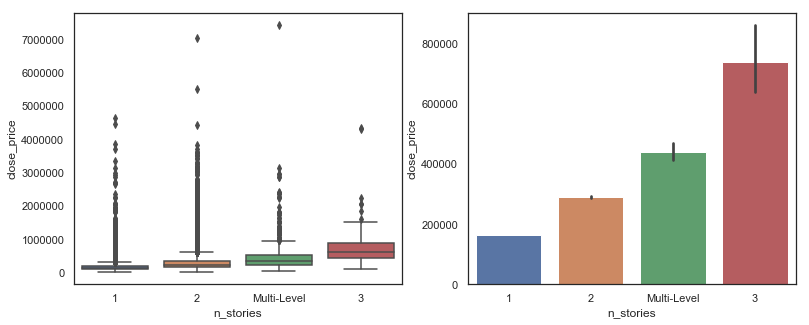

In [286]:
cat_plot(df,column=feat,ycolumn='close_price')

In [287]:
temp = df.groupby(by=feat)['close_price'].mean().reset_index()
temp.rename(columns={'close_price':'avg_close_price_by_stories'},inplace=True)
temp['list_count_by_stories'] = df.groupby(by=feat)['close_price'].count().values
df = pd.merge(df,temp,how='left',on='n_stories')

In [288]:
feat = cat_features[9]
print(feat)
print(df[feat].nunique())
df[feat].unique()

spa_hottub_yn
1


array([nan, True], dtype=object)

In [ ]:
# We can assume nan to be false 

In [289]:
df[feat].fillna(False).value_counts()

False    96030
True      3970
Name: spa_hottub_yn, dtype: int64

In [290]:
df[feat] = df[feat].fillna(False)


In [291]:
df[feat] = np.array(df[feat],dtype='int64')

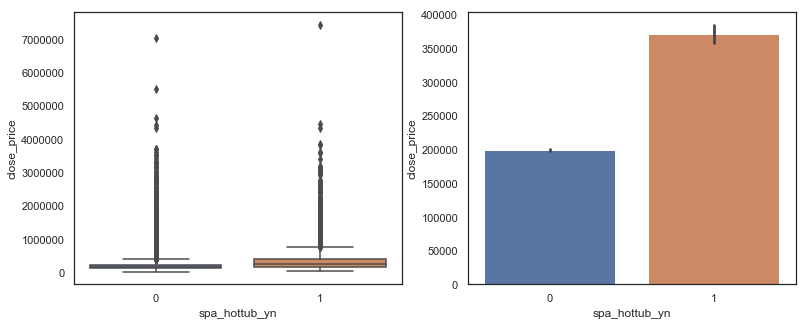

In [292]:
cat_plot(df,column=feat,ycolumn='close_price')

price with spa hot tub is higher

In [293]:
feat = cat_features[10]
print(feat)
print(df[feat].nunique())
df[feat].unique()

rooms
5914


array([nan, "['Game']", "['Converted Garage', 'Game']", ...,
       "['Formal Living', 'See Agent', 'Storage', 'Utility', 'Workshop']",
       "['Formal Living', 'Game', 'Media/Home Theater']",
       "['Great', 'Media/Home Theater', 'Office/Study', 'Sun', 'Utility']"],
      dtype=object)

In [294]:
drop_columns_list.append(feat)

In [295]:
feat = cat_features[11]
print(feat)
print(df[feat].nunique())
df[feat].unique()

pool_on_prop
2


array([False, nan, True], dtype=object)

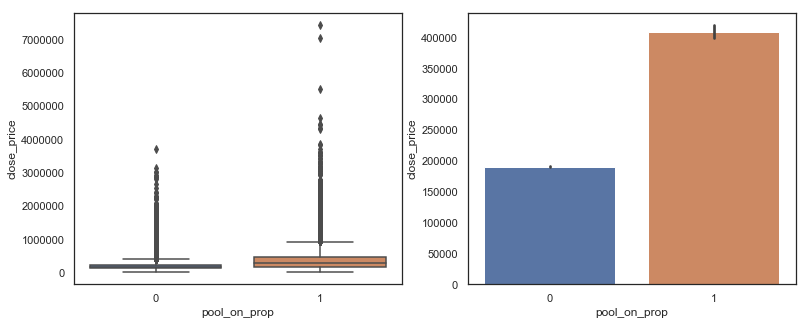

In [296]:
df[feat] = df[feat].fillna(False)
df[feat] = np.array(df[feat],dtype='int64')
cat_plot(df,column=feat,ycolumn='close_price')

In [297]:
feat = cat_features[12]
print(feat)
print(df[feat].nunique())
df[feat].unique()

water_source
25


array(["['City']", "['MUD']", "['City', 'MUD']",
       "['MUD', 'Water District']", "['Water District']",
       "['Well On Property']", "['Private Water Co']",
       "['City', 'None Available']",
       "['Private Water Co', 'Well On Property']", nan,
       "['Water District', 'Well On Property']",
       "['City', 'Well On Property']",
       "['Private Water Co', 'Water District']",
       "['City', 'Water District']", "['City', 'Private Water Co']",
       "['None Available']", "['MUD', 'Private Water Co']",
       "['MUD', 'Well On Property']", "['See Agent']",
       "['City', 'See Agent']", "['Water District', 'Well Needed']",
       "['Well Needed']", "['Private Water Co', 'See Agent']",
       "['See Agent', 'Well On Property']",
       "['See Agent', 'Water District']", "['MUD', 'See Agent']"],
      dtype=object)

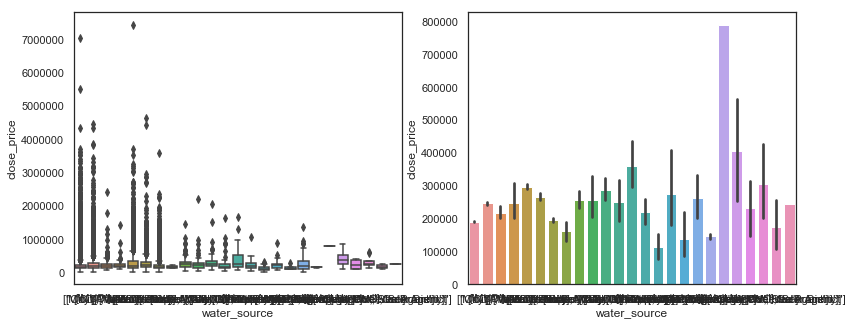

In [298]:
cat_plot(df,column=feat,ycolumn='close_price')

In [301]:
df[feat].values

array(["['City']", "['City']", "['City']", ..., "['City']", "['City']",
       "['MUD']"], dtype=object)

In [308]:
# Most common source of water
na="['City']"

df[feat] = df[feat].fillna(na)

In [333]:
def split(x):
    """Extending water sources and creating one hot encoding and also
    counting it"""
    y = ''.join(x) # dealing with list to str
    z = y.split(',')[0][2:-2] # removing last and first 2 string char ('[]')
    return z
def split_2(x):
    """Extending water sources and creating one hot encoding and also
    counting it"""
    y = ''.join(x) # dealing with list to str
    try:
        z = y.split(',')[1][2:-2] # removing last and first 2 string char ('[]')
    except:
        z = 'None'
    return z
first = df[feat].apply(lambda x:split(x))
second = df[feat].apply(lambda x:split_2(x))
#df[feat].str.split(',',expand=True)


In [338]:
water_sources = set(first).union(set(second))
water_sources.remove('None')

In [349]:
temp = df.copy()
for water_source in water_sources:
    df[feat+'_'+water_source]= [1 if ws==water_source or ws2==water_source else 0 for ws,ws2 in zip(first,second)]
df[feat+'_count'] = [1 if x == 'None' else 2 for x in second]

In [350]:
df.head()

,mls,matrix_id,mls_number,parcel_number,address,unit_number,city,county,zipcode,lat,long,property_subtype,subdiv_name,baths_full,baths_half,baths_total,beds_total,sqft_total,lot_size_acres,n_stories,year_built,num_living,num_main_lvl_beds,num_other_lvl_beds,num_dining_area,num_fireplaces,spa_hottub_yn,rooms,pool_on_prop,water_source,fema_100yr_flood,hoa_yn,hoa_fee_freq,status,close_price,agent_mls_id,agent_full_name,photo_count,tax_amount,tax_year,cdom,close_date,close_year,which_floor,avg_close_price_by_city,list_count_by_city,avg_close_price_by_county,list_count_by_county,avg_close_price_by_stories,list_count_by_stories,water_source_Cit,water_source_Private Water C,water_source_See Agen,water_source_City,water_source_Water Distric,water_source_Private Water Co,water_source_MUD,water_source_None Available,water_source_Water District,water_source_See Agent,water_source_Well Needed,water_source_Well On Property,water_source_MU,water_source_count
0,actris,407367,363606,01681104080000,8711 Crest Ridge Cir,NaN,Austin,Travis,78750.0,30.43546,-97.78609,House,BALCONES VILLAGE,2.0,NaN,2.0,4.0,2313.0,NaN,1,1976.0,2.0,0.0,0.0,NaN,1.0,0,NaN,0,['City'],No,0,NaN,Sold,146664.08856,316968.0,Roger Hill,1.0,2762.0,1994.0,170.0,1996-05-17,1996,1,237779.662761,51829.0,237270.502841,58238,162988.110827,67767,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1,actris,408400,376227,01641301030000,10605 Tweedsmuir Dr,NaN,Austin,Travis,78750.0,30.42698,-97.79538,House,PARK AT SPICEWOOD SPRINGS PH,2.0,1.0,3.0,4.0,2416.0,NaN,2,1984.0,1.0,0.0,0.0,NaN,1.0,0,NaN,0,['City'],No,0,NaN,Sold,165395.37048,430361.0,Mary Dix,1.0,4442.0,1995.0,82.0,1996-06-21,1996,1,237779.662761,51829.0,237270.502841,58238,289910.693599,31162,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2,actris,409486,383227,01701309150000,9422 Spring Hollow Dr,NaN,Austin,Travis,78750.0,30.44019,-97.79796,House,BALCONES VILLAGE SEC 6,2.0,1.0,3.0,4.0,0.0,NaN,1,1977.0,3.0,0.0,0.0,NaN,1.0,0,['Game'],0,['City'],No,0,NaN,Sold,158947.50615,437887.0,Erma Christopher,1.0,3901.0,1995.0,24.0,1996-06-21,1996,1,237779.662761,51829.0,237270.502841,58238,162988.110827,67767,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3,actris,409485,383212,163970000B0006,12106 Grey Rock Ln,NaN,Austin,Williamson,78750.0,30.45678,-97.81006,House,GREY ROCK VILLAGE AT ANDERSO,2.0,NaN,2.0,3.0,1668.0,NaN,1,1977.0,2.0,0.0,0.0,NaN,1.0,0,NaN,0,['MUD'],No,0,NaN,Sold,83767.47960,255263.0,Frederick Sims,1.0,2347.0,1995.0,24.0,1996-06-21,1996,1,237779.662761,51829.0,159864.150031,30235,162988.110827,67767,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,actris,407945,372634,01661317070000,9009 Westerkirk Dr,NaN,Austin,Travis,78750.0,30.43006,-97.79292,House,PARK AT SPICEWOOD SPRINGS PH,3.0,1.0,4.0,5.0,3644.0,NaN,2,1990.0,3.0,0.0,0.0,NaN,1.0,0,['Game'],0,['MUD'],No,0,NaN,Sold,263160.84435,420040.0,Sara Michael,1.0,6700.0,1995.0,112.0,1996-06-21,1996,1,237779.662761,51829.0,237270.502841,58238,289910.693599,31162,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [351]:
feat = cat_features[13]
print(feat)
print(df[feat].nunique())
df[feat].unique()

fema_100yr_flood
5


array(['No', 'See Agent', 'Yes', 'Unknown', 'Partial'], dtype=object)

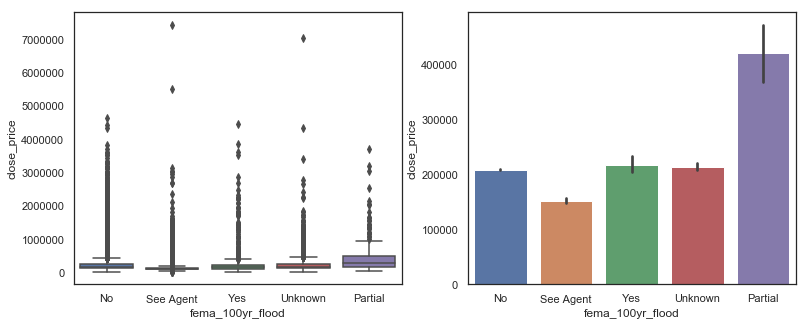

In [352]:
cat_plot(df,column=feat,ycolumn='close_price')

In [353]:
# One Hot Encoding
fema=df[feat].unique()
for x in fema:
    df[feat+'_'+x] = [1 if fm == x else 0 for fm in df[feat]]

In [355]:
feat = cat_features[14]
print(feat)
print(df[feat].nunique())
df[feat].unique()

hoa_fee_freq
3


array([nan, 'Annually', 'Monthly', 'Quarterly'], dtype=object)

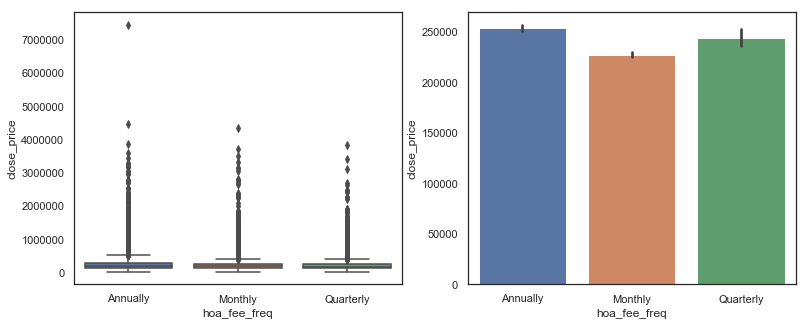

In [356]:
cat_plot(df,column=feat,ycolumn='close_price')

In [357]:
df[feat].value_counts()

Annually     20400
Monthly      15991
Quarterly     3970
Name: hoa_fee_freq, dtype: int64

In [358]:
# This does not show high difference 
# It shows equal distribution
drop_columns_list.append(feat)

In [359]:
feat = cat_features[15]
print(feat)
print(df[feat].nunique())
df[feat].unique()

status
1


array(['Sold'], dtype=object)

In [360]:
drop_columns_list.append(feat)

In [361]:
feat = cat_features[16]
print(feat)
print(df[feat].nunique())
df[feat].unique()

agent_full_name
5009


array(['Roger Hill', 'Mary Dix', 'Erma Christopher', ..., 'Dana Low',
       'Cheryll Gray', 'Wm Rodwell'], dtype=object)

This won't be available for Amne house valuation.
 So, we can't use this always. Removing this from our analysis

In [362]:
drop_columns_list.append(feat)

zipcode
Correlation: nan


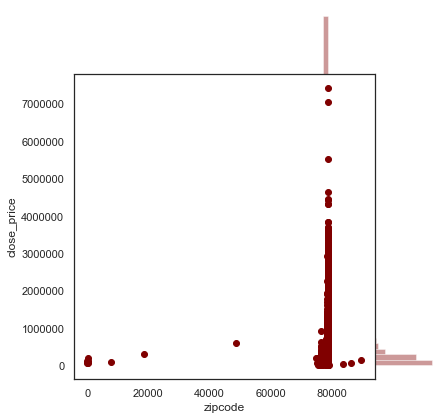

Number Of Missing Point
1
************************************************************
lat
Correlation: nan


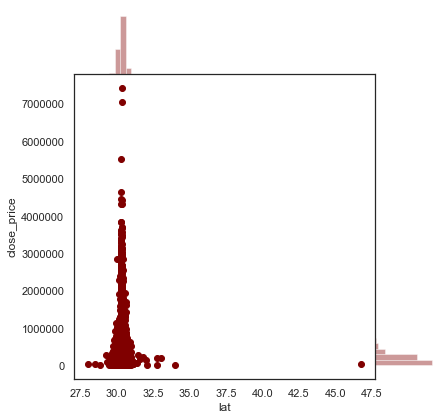

Number Of Missing Point
370
************************************************************
long
Correlation: nan


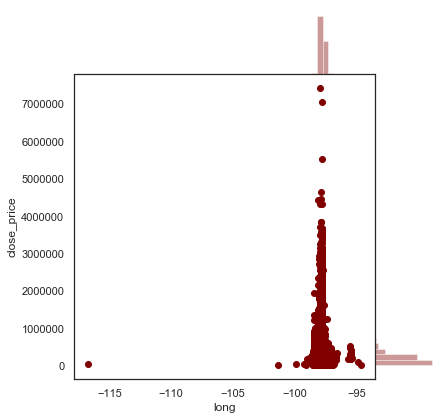

Number Of Missing Point
370
************************************************************
baths_full
Correlation: 0.611044017974954


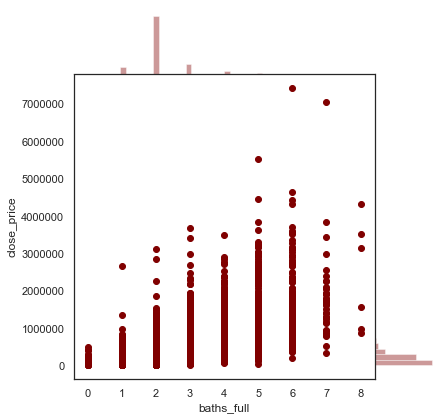

Number Of Missing Point
0
************************************************************
baths_half
Correlation: nan


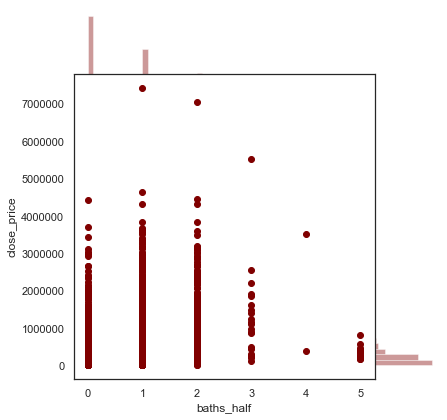

Number Of Missing Point
3018
************************************************************
baths_total
Correlation: 0.6197172485187935


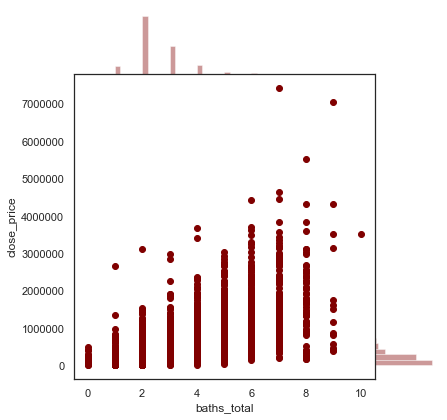

Number Of Missing Point
0
************************************************************
beds_total
Correlation: 0.36966744747233704


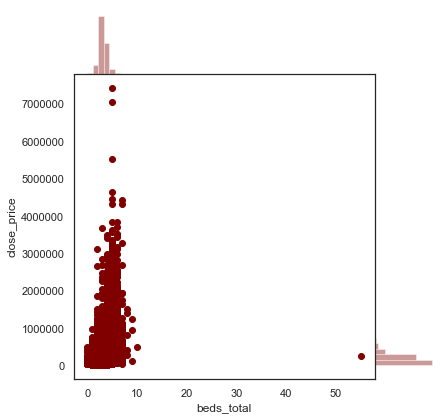

Number Of Missing Point
0
************************************************************
sqft_total
Correlation: nan


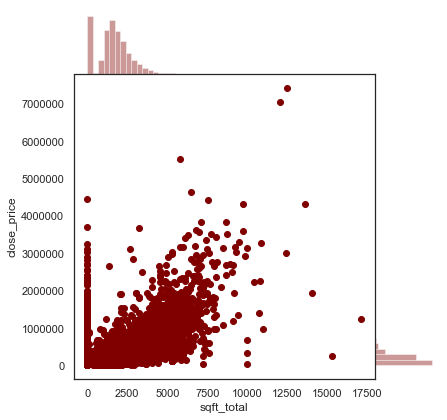

Number Of Missing Point
1
************************************************************
lot_size_acres
Correlation: nan


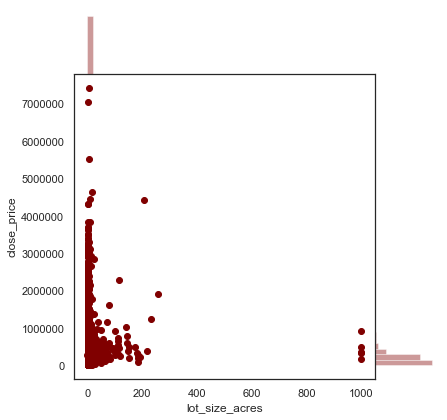

Number Of Missing Point
31039
************************************************************
year_built
Correlation: nan


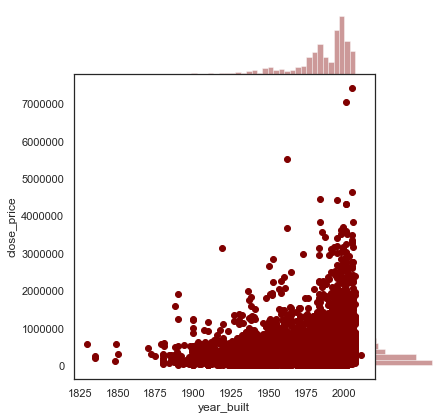

Number Of Missing Point
63
************************************************************
num_living
Correlation: 0.5032348008357898


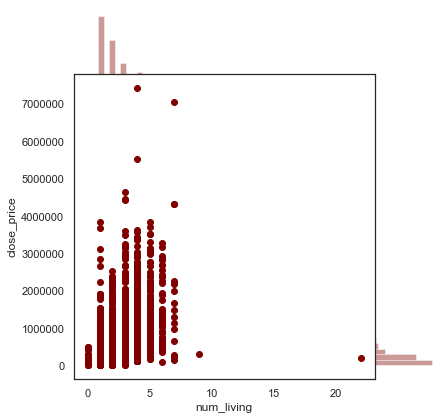

Number Of Missing Point
0
************************************************************
num_main_lvl_beds
Correlation: -0.08335470797832686


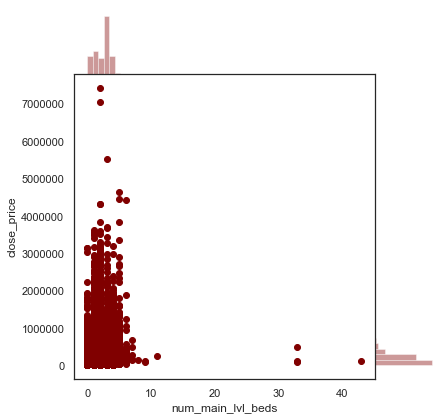

Number Of Missing Point
0
************************************************************
num_other_lvl_beds
Correlation: 0.2944563063808957


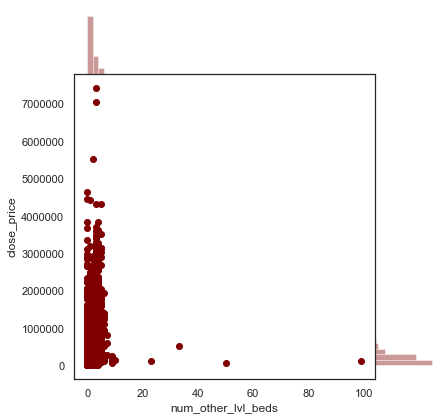

Number Of Missing Point
0
************************************************************
num_dining_area
Correlation: nan


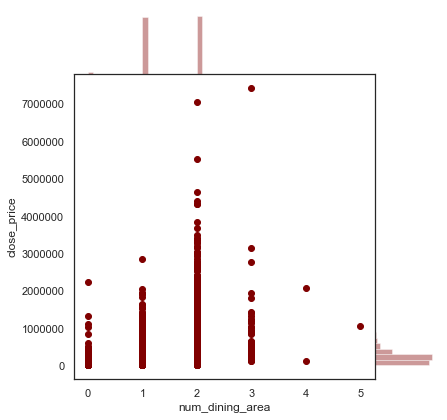

Number Of Missing Point
67053
************************************************************
num_fireplaces
Correlation: nan


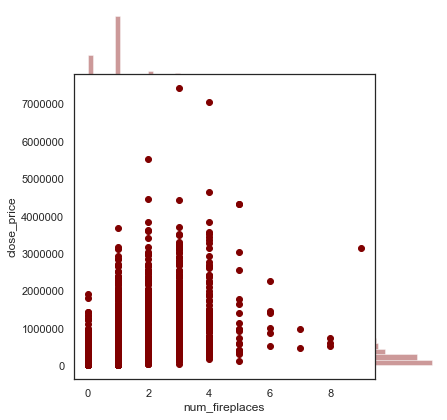

Number Of Missing Point
574
************************************************************
close_price
Correlation: 1.0


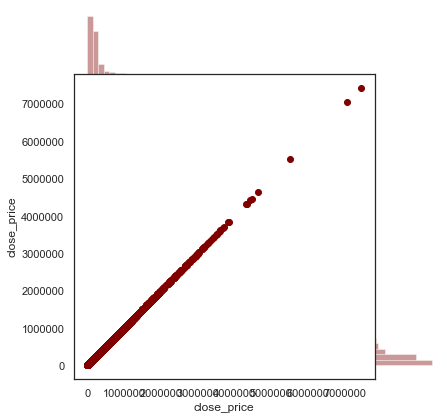

Number Of Missing Point
0
************************************************************
agent_mls_id
Correlation: nan


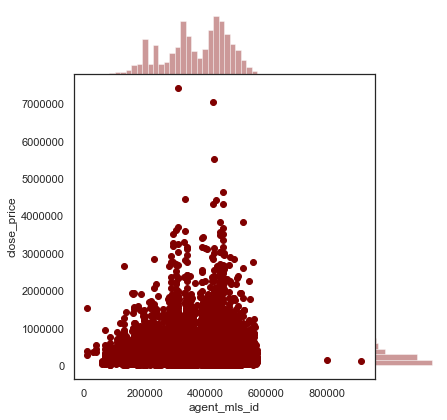

Number Of Missing Point
7243
************************************************************
photo_count
Correlation: 0.20852827606669466


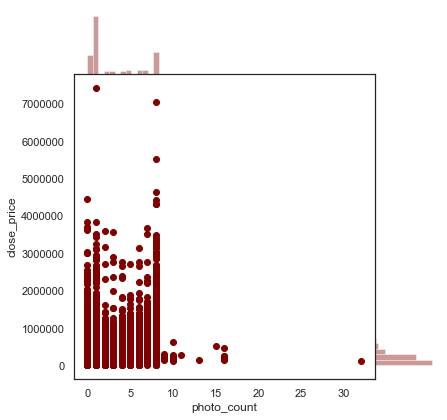

Number Of Missing Point
0
************************************************************
tax_amount
Correlation: nan


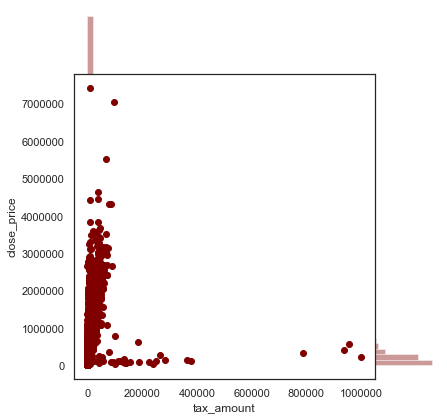

Number Of Missing Point
6898
************************************************************
tax_year
Correlation: nan


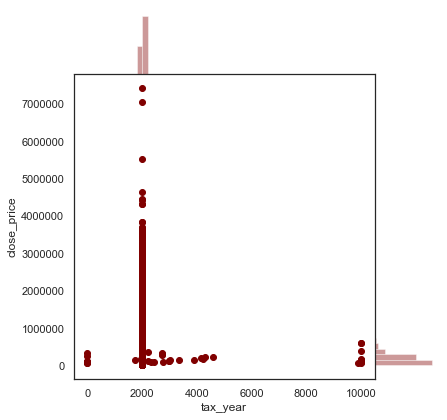

Number Of Missing Point
77
************************************************************
cdom
Correlation: 0.16366087723039419


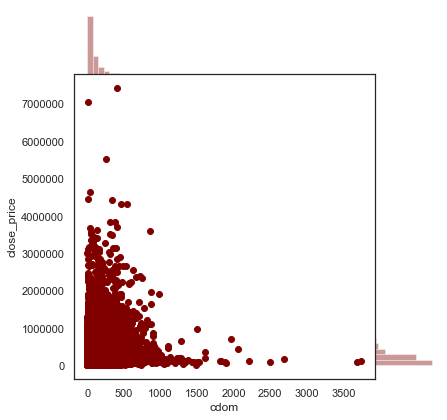

Number Of Missing Point
0
************************************************************


In [367]:
for var in num_features:
    print(var)
    numerical_plot(df,column=var,ycolumn='close_price')
    print('Number Of Missing Point')
    print(df[var].isna().sum())
    print('**'*30)

In [410]:
num_features

Index(['zipcode', 'lat', 'long', 'baths_full', 'baths_half', 'baths_total', 'beds_total', 'sqft_total', 'lot_size_acres', 'year_built', 'num_living', 'num_main_lvl_beds', 'num_other_lvl_beds', 'num_dining_area', 'num_fireplaces', 'close_price', 'agent_mls_id', 'photo_count', 'tax_amount', 'tax_year', 'cdom'], dtype='object')

### Dealing with Missing Data 


In [370]:
df.to_csv('../data/processed/processed.csv',index=None)


In [449]:
df = pd.read_csv('../data/processed/processed.csv')

- Zipcode = KNN with long and lat
- long and lat based knn on zipcode
- baths_half = totalbaths-baths_full minimum (0)
- sqft total =Dropping that row
- lot size = knn with sqft_total
- year_built = knn with year,sqft,long,lat
- num_fireplaces = 0
- tax_amount = knn with long,lat,sqft,year_built

In [453]:
knn_reg_zipcode = KNNImputer_reg()
input_columns = ['long','lat']
knn_reg_zipcode.fit(df,'zipcode',input_columns=input_columns)

y = knn_reg_zipcode.transform(df.dropna(subset=['long','lat']))
df.loc[df[['long','lat']].isna().sum(axis=1)==0,'zipcode'] = y

In [454]:
df = df.dropna(subset=['zipcode'],axis=0)

In [455]:
df['zipcode'].isna().sum()

0

In [456]:
knn_reg_long = KNNImputer_reg()
input_columns = ['zipcode']
knn_reg_long.fit(df,'long',input_columns=input_columns)



In [457]:
df['long'] = knn_reg_long.transform(df)

In [458]:
knn_reg_lat = KNNImputer_reg()
input_columns = ['zipcode']
knn_reg_lat.fit(df,'lat',input_columns=input_columns)
df['lat'] = knn_reg_lat.transform(df)


In [459]:
df.head()

,mls,matrix_id,mls_number,parcel_number,address,unit_number,city,county,zipcode,lat,long,property_subtype,subdiv_name,baths_full,baths_half,baths_total,beds_total,sqft_total,lot_size_acres,n_stories,year_built,num_living,num_main_lvl_beds,num_other_lvl_beds,num_dining_area,num_fireplaces,spa_hottub_yn,rooms,pool_on_prop,water_source,fema_100yr_flood,hoa_yn,hoa_fee_freq,status,close_price,agent_mls_id,agent_full_name,photo_count,tax_amount,tax_year,cdom,close_date,close_year,which_floor,avg_close_price_by_city,list_count_by_city,avg_close_price_by_county,list_count_by_county,avg_close_price_by_stories,list_count_by_stories,water_source_Cit,water_source_Private Water C,water_source_See Agen,water_source_City,water_source_Water Distric,water_source_Private Water Co,water_source_MUD,water_source_None Available,water_source_Water District,water_source_See Agent,water_source_Well Needed,water_source_Well On Property,water_source_MU,water_source_count,fema_100yr_flood_No,fema_100yr_flood_See Agent,fema_100yr_flood_Yes,fema_100yr_flood_Unknown,fema_100yr_flood_Partial
0,actris,407367,363606,01681104080000,8711 Crest Ridge Cir,NaN,Austin,Travis,78750.0,30.43546,-97.78609,House,BALCONES VILLAGE,2.0,NaN,2.0,4.0,2313.0,NaN,1,1976.0,2.0,0.0,0.0,NaN,1.0,0,NaN,0,['City'],No,0,NaN,Sold,146664.08856,316968.0,Roger Hill,1.0,2762.0,1994.0,170.0,1996-05-17,1996,1,237779.662761,51829.0,237270.502841,58238,162988.110827,67767,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
1,actris,408400,376227,01641301030000,10605 Tweedsmuir Dr,NaN,Austin,Travis,78750.0,30.42698,-97.79538,House,PARK AT SPICEWOOD SPRINGS PH,2.0,1.0,3.0,4.0,2416.0,NaN,2,1984.0,1.0,0.0,0.0,NaN,1.0,0,NaN,0,['City'],No,0,NaN,Sold,165395.37048,430361.0,Mary Dix,1.0,4442.0,1995.0,82.0,1996-06-21,1996,1,237779.662761,51829.0,237270.502841,58238,289910.693599,31162,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
2,actris,409486,383227,01701309150000,9422 Spring Hollow Dr,NaN,Austin,Travis,78750.0,30.44019,-97.79796,House,BALCONES VILLAGE SEC 6,2.0,1.0,3.0,4.0,0.0,NaN,1,1977.0,3.0,0.0,0.0,NaN,1.0,0,['Game'],0,['City'],No,0,NaN,Sold,158947.50615,437887.0,Erma Christopher,1.0,3901.0,1995.0,24.0,1996-06-21,1996,1,237779.662761,51829.0,237270.502841,58238,162988.110827,67767,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
3,actris,409485,383212,163970000B0006,12106 Grey Rock Ln,NaN,Austin,Williamson,78750.0,30.45678,-97.81006,House,GREY ROCK VILLAGE AT ANDERSO,2.0,NaN,2.0,3.0,1668.0,NaN,1,1977.0,2.0,0.0,0.0,NaN,1.0,0,NaN,0,['MUD'],No,0,NaN,Sold,83767.47960,255263.0,Frederick Sims,1.0,2347.0,1995.0,24.0,1996-06-21,1996,1,237779.662761,51829.0,159864.150031,30235,162988.110827,67767,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0
4,actris,407945,372634,01661317070000,9009 Westerkirk Dr,NaN,Austin,Travis,78750.0,30.43006,-97.79292,House,PARK AT SPICEWOOD SPRINGS PH,3.0,1.0,4.0,5.0,3644.0,NaN,2,1990.0,3.0,0.0,0.0,NaN,1.0,0,['Game'],0,['MUD'],No,0,NaN,Sold,263160.84435,420040.0,Sara Michael,1.0,6700.0,1995.0,112.0,1996-06-21,1996,1,237779.662761,51829.0,237270.502841,58238,289910.693599,31162,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0


In [460]:
df['baths_half'] = df['baths_total']-df['baths_full']


In [461]:
df.dropna(subset=['sqft_total'],axis=0,inplace=True)

In [462]:
df['sqft_total'].isna().sum()

0

In [463]:
knn_reg_lot = KNNImputer_reg()
input_columns = ['sqft_total','long','lat']
knn_reg_lot.fit(df,'lot_size_acres',input_columns=input_columns)
df['lot_size_acres'] = knn_reg_lot.transform(df)


In [464]:
knn_reg_year_blt = KNNImputer_reg()
input_columns = ['sqft_total','long','lat']
knn_reg_year_blt.fit(df,'year_built',input_columns=input_columns)
df['year_built'] = knn_reg_year_blt.transform(df)


In [465]:
df['num_fireplaces'] = df['num_fireplaces'].fillna(0)

In [466]:
knn_reg_year_tax = KNNImputer_reg()
input_columns = ['sqft_total','long','lat','year_built']
knn_reg_year_tax.fit(df,'tax_amount',input_columns=input_columns)
df['tax_amount'] = knn_reg_year_tax.transform(df)


In [467]:
drop_columns_list.append('num_dining_area')
drop_columns_list.append('agent_mls_id')
drop_columns_list.append('photo_count')
drop_columns_list.append('tax_year')
drop_columns_list.append('unit_number')
drop_columns_list.append('parcel_number')

In [468]:
print('data dimensions before dropping the columns: ',df.shape)
for col in df.columns:
    if col in drop_columns_list:
        df.drop(col,axis=1,inplace=True)
print('data dimensions after dropping the columns: ',df.shape)

data dimensions before dropping the columns:  (99999, 69)
data dimensions after dropping the columns:  (99999, 58)


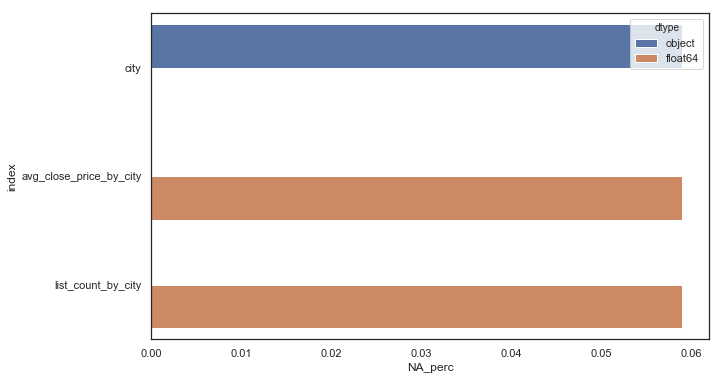

In [469]:

# aggregate all null values 
df_null = df.isna().sum()*100/df.shape[0]
df_null = df_null.reset_index()
df_null.rename(columns={0:'NA_perc'},inplace=True)
df_null['dtype'] = df.dtypes.values

# get rid of all the values with 0 missing values
df_null = df_null[df_null['NA_perc']>0].sort_values(by='NA_perc',ascending=False)
fig,ax = plt.subplots(1,figsize =(10,6))
sns.barplot(x=df_null['NA_perc'],y=df_null['index'],hue=df_null['dtype'])
#df_null.plot(kind='bar');

In [470]:
df.dropna(inplace=True)

In [471]:
df.shape

(99940, 58)

In [472]:
df.to_csv('../data/processed/model.csv',index=None)

## Missing Data

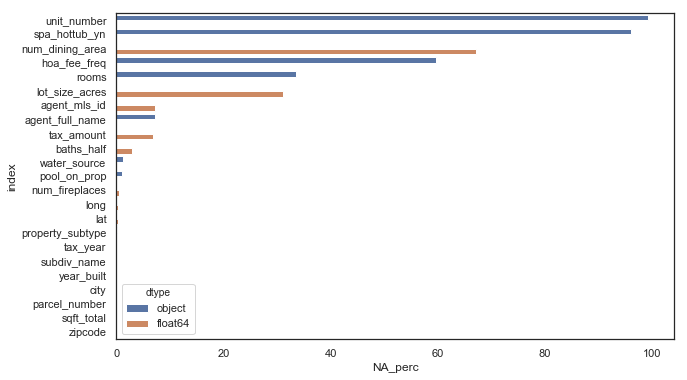

In [101]:
# aggregate all null values 
df_null = df.isna().sum()*100/df.shape[0]
df_null = df_null.reset_index()
df_null.rename(columns={0:'NA_perc'},inplace=True)
df_null['dtype'] = df.dtypes.values

# get rid of all the values with 0 missing values
df_null = df_null[df_null['NA_perc']>0].sort_values(by='NA_perc',ascending=False)
fig,ax = plt.subplots(1,figsize =(10,6))
sns.barplot(x=df_null['NA_perc'],y=df_null['index'],hue=df_null['dtype'])
#df_null.plot(kind='bar');

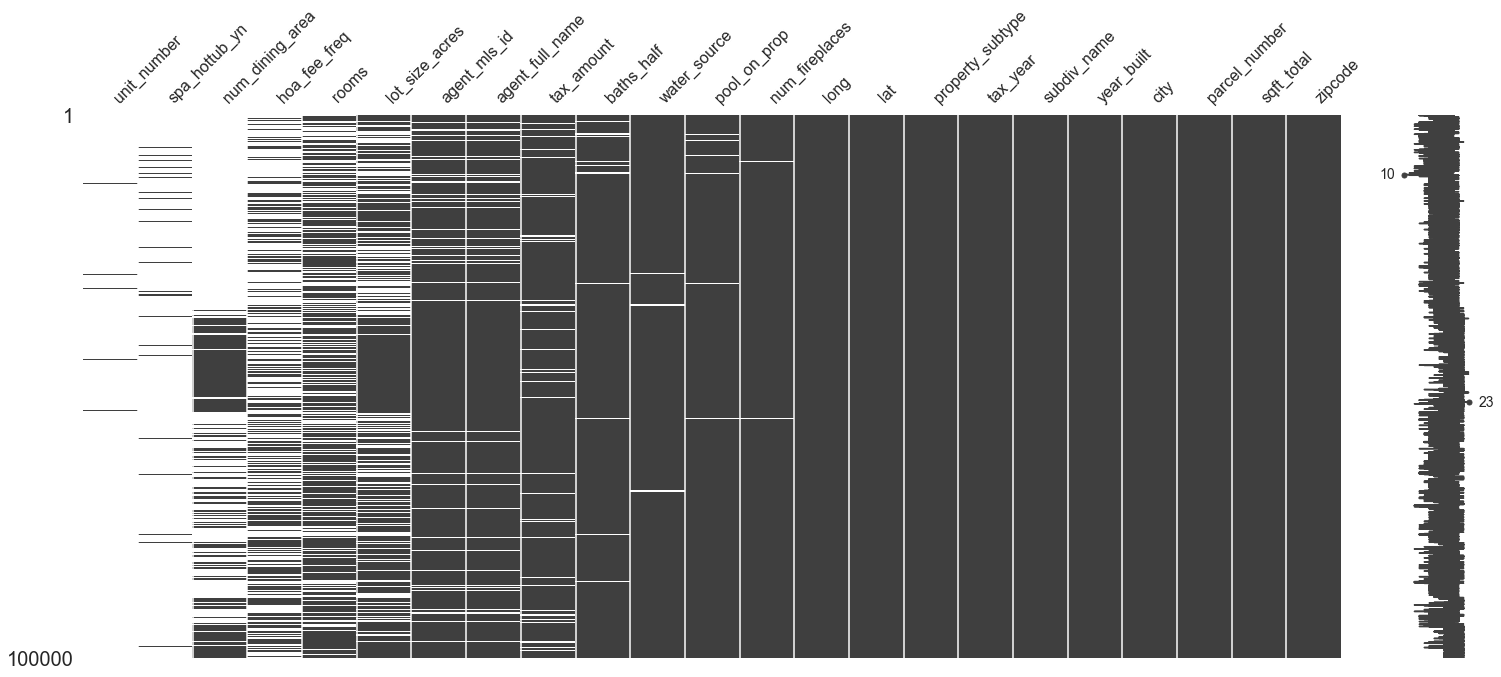

In [103]:
msno.matrix(df[df_null['index'].values])

In [107]:
#df['missing_values']df.isna().sum(axis=1)

## Data Validating

- Writing pipelines to do automated feature engineering
    - Imputing missing values (or removing values)
    - Scaling data
    - Transforming objects (strings, dates, etc.) to numerical vectors
    - Creating new features

In [474]:
dtype_df = df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,28
1,float64,21
2,object,9


In [475]:
df[df.columns[df.dtypes == 'object']].head()

,mls,address,city,county,property_subtype,n_stories,water_source,fema_100yr_flood,close_date
0,actris,8711 Crest Ridge Cir,Austin,Travis,House,1,['City'],No,1996-05-17
1,actris,10605 Tweedsmuir Dr,Austin,Travis,House,2,['City'],No,1996-06-21
2,actris,9422 Spring Hollow Dr,Austin,Travis,House,1,['City'],No,1996-06-21
3,actris,12106 Grey Rock Ln,Austin,Williamson,House,1,['MUD'],No,1996-06-21
4,actris,9009 Westerkirk Dr,Austin,Travis,House,2,['MUD'],No,1996-06-21


dropping all these column

In [476]:
print('data dimensions before dropping the columns: ',df.shape)
for col in df.columns:
    if col in df.columns[df.dtypes == 'object']:
        df.drop(col,axis=1,inplace=True)
print('data dimensions after dropping the columns: ',df.shape)

data dimensions before dropping the columns:  (99940, 58)
data dimensions after dropping the columns:  (99940, 49)


In [479]:
drop_columns_list.append('matrix_id')
drop_columns_list.append('mls_number')
print('data dimensions before dropping the columns: ',df.shape)
for col in df.columns:
    if col in drop_columns_list:
        df.drop(col,axis=1,inplace=True)
print('data dimensions after dropping the columns: ',df.shape)

data dimensions before dropping the columns:  (99940, 49)
data dimensions after dropping the columns:  (99940, 47)


## Model Selection & Training

- Try different models and choose best 2-5 models
    - Use K-Fold cross-validation to validate which models are the best
- Typical ML models include kNN, SVM, linear/logistic regression, ensemble methods (RF, XGB), neural networks, etc.
- [Optional] Save experimental models to pickle file.

In [481]:
y_column = 'close_price'
model_columns = [col for col in df.columns if col !=y_column]
model_columns

['zipcode',
 'lat',
 'long',
 'baths_full',
 'baths_half',
 'baths_total',
 'beds_total',
 'sqft_total',
 'lot_size_acres',
 'year_built',
 'num_living',
 'num_main_lvl_beds',
 'num_other_lvl_beds',
 'num_fireplaces',
 'spa_hottub_yn',
 'pool_on_prop',
 'hoa_yn',
 'tax_amount',
 'cdom',
 'close_year',
 'which_floor',
 'avg_close_price_by_city',
 'list_count_by_city',
 'avg_close_price_by_county',
 'list_count_by_county',
 'avg_close_price_by_stories',
 'list_count_by_stories',
 'water_source_Cit',
 'water_source_Private Water C',
 'water_source_See Agen',
 'water_source_City',
 'water_source_Water Distric',
 'water_source_Private Water Co',
 'water_source_MUD',
 'water_source_None Available',
 'water_source_Water District',
 'water_source_See Agent',
 'water_source_Well Needed',
 'water_source_Well On Property',
 'water_source_MU',
 'water_source_count',
 'fema_100yr_flood_No',
 'fema_100yr_flood_See Agent',
 'fema_100yr_flood_Yes',
 'fema_100yr_flood_Unknown',
 'fema_100yr_flood_Parti

### Train, val, test split

In [484]:
X = df[model_columns]
y = df[y_column]
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val    = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [486]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(63961, 46)
(15991, 46)
(19988, 46)


In [ ]:
# Evaluation metric to be RMSE
# For business understanding we can use MAPE

In [490]:
# Set a baseling based on Linear Regression model prediction
reg = LinearRegression(normalize = False, fit_intercept=True)
score = cross_val_score(reg, X_train, y_train, cv=10,scoring = "neg_mean_squared_error")

print("cv_rmse",np.mean(np.sqrt(np.abs(score))))

cv_rmse 121418.1071360051


In [492]:
reg.fit(X_train,y_train)
y_val_pred = reg.predict(X_val)


## Model Evaluation

- Final evaluation on the test set
- Calculation of confidence intervals using t-score or z-scores to give a range of values and confidence level

In [525]:
def mean_absolute_percentage_error(y_true,y_pred): 
    #y_true, y_pred = check_arrays(y_true, y_pred)
    return np.abs((y_true - y_pred) / y_true) * 100

def model_validation(model,Xval,yval):
    X_val = Xval.copy()
    y_val = yval.copy()
    y_val_pred = model.predict(X_val)
    
    # Plotting Actual vs Scatter plot
    fig,ax = plt.subplots(1,figsize=(5,5))
    ax.scatter(y_val,y_val_pred)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x,color='red')
    plt.show()
    
    
    X_val['Actual'] = y_val
    X_val['Predicted'] = y_val_pred
    X_val['price_bin'] = pd.cut(y_val,bins=[0,50000,100000,150000,200000,300000,400000,500000,1000000,10000000])
    X_val['MAPE'] = mean_absolute_percentage_error(y_val.values,y_val_pred)
    
    #X_val[['Actual','Predicted','price_bin']].groupby(by='price_bin').agg()
    
    fig,ax = plt.subplots(1,figsize=(10,5))
    sns.boxplot(x='price_bin', y='MAPE', data=X_val)
    ax.set_ylabel('MAPE')
    ax.set_xlabel('price_bin')
    plt.xticks(rotation=40)
    plt.show()
    
def mean_absolute_percentage_error(y_true,y_pred): 
    #y_true, y_pred = check_arrays(y_true, y_pred)
    return np.abs((y_true - y_pred) / y_true) * 100

def model_validation2(model,Xval,yval):
    X_val = Xval.copy()
    y_val = yval.copy()
    y_val_pred = model.predict(X_val)
    
    fig,ax = plt.subplots(1,figsize=(5,5))
    ax.scatter(y_val,y_val_pred)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x,color='red')
    plt.show()
    X_val['Actual'] = y_val
    X_val['Predicted'] = y_val_pred
    X_val['price_bin'] = pd.cut(y_val,bins=[50000,100000,150000,200000,300000,400000,500000,1000000,10000000])
    X_val['MAPE'] = mean_absolute_percentage_error(y_val.values,y_val_pred)
    
    #X_val[['Actual','Predicted','price_bin']].groupby(by='price_bin').agg()
    
    fig,ax = plt.subplots(1,figsize=(10,5))
    sns.barplot(x='price_bin', y='MAPE', data=X_val)
    ax.set_ylabel('MAPE')
    ax.set_xlabel('price_bin')
    plt.xticks(rotation=40)
    plt.show()
    

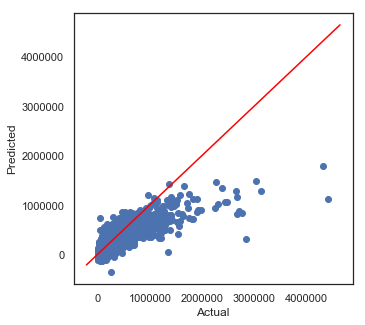

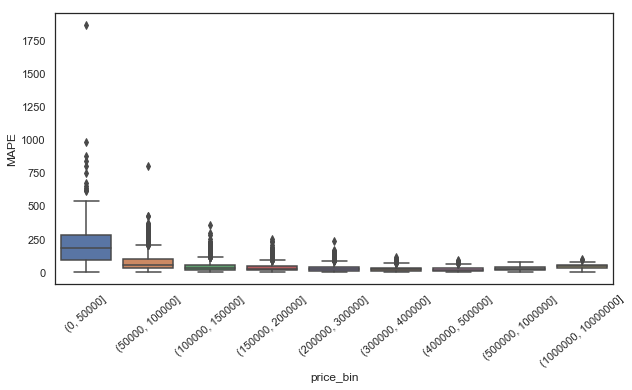

In [526]:
model_validation(reg,X_val,y_val)

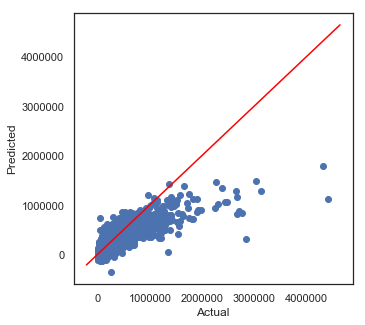

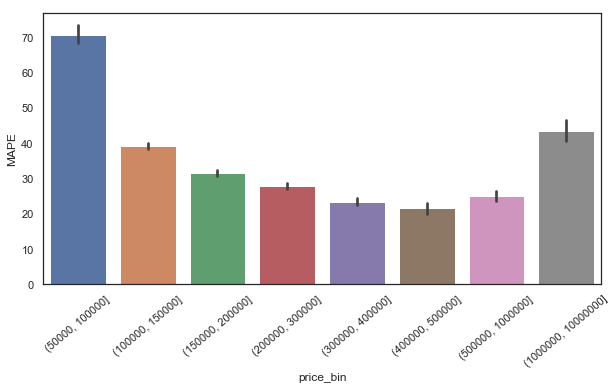

In [527]:
model_validation2(reg,X_val,y_val)

- Xgboost would be better choice as this can better approximate data.
- Random Forest can also be good choice as it combine all the tree based model

In [530]:
xgbr = xgb.XGBRegressor(max_depth = 8, learning_rate = 0.01, n_estimators=500, n_jobs = -1, 
                   gamma = 0, subsample = 0.1, reg_alpha=0, reg_lambda = 0, 
                   base_score = 0.5)

In [531]:
xgbr.fit(X_train,y_train)
y_val_pred = reg.predict(X_val)


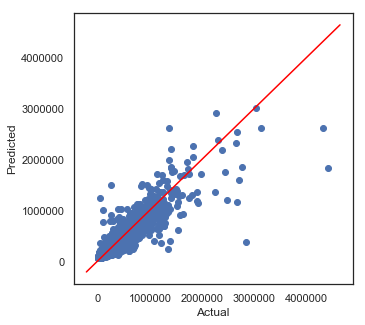

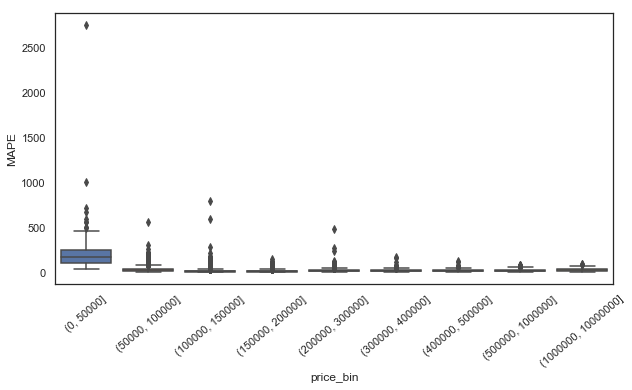

In [532]:
model_validation(xgbr,X_val,y_val)

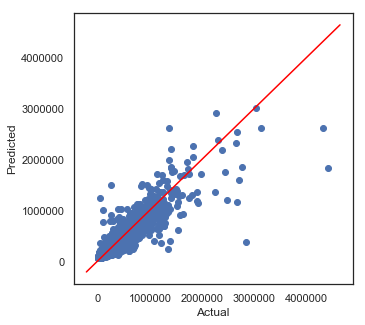

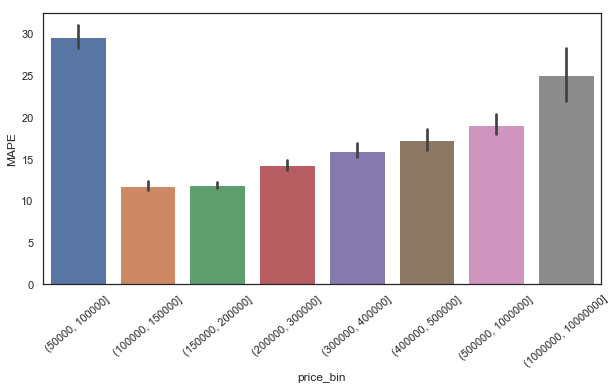

In [533]:
model_validation2(xgbr,X_val,y_val)

## Model Tuning

- Tune the top chosen model(s) and tune hyperparameters
    - Ideally, use Bayes Optimization `BayesSearchCV` to optimally search for best hyperparameters for the model
        - `BayesSearchCV` is from `skopt` or `scikit-optimize` library (There are many different Bayesian Optimization implementations) 
- Below are some common search spaces for ensemble algorithms (which tend to have a lot of hyperparameters), specifically:
    - Random Forest (Variation of Bagging)
    - xgboost (Gradient Boosting)
    - lightgbm (Gradient Boosting)
        - https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [ ]:
# Random Forest (Classificaton Example)

from sklearn.ensemble import RandomForestClassifier

rf_search_space = {
    'n_estimators': (100, 600),
    'max_depth': (1, 50),  
    'max_features': (1, n_features),
    'min_samples_leaf': (1, 50),  # integer valued parameter
    'min_samples_split': (2, 50),
}

rf_bayes_tuner = BayesSearchCV(
    estimator=RandomForestClassifier(oob_score=True, random_state=1, n_jobs=2),
    search_spaces=rf_search_space,
    n_iter=20,
    optimizer_kwargs={'base_estimator': 'RF'},
    scoring='neg_log_loss',
    n_jobs=5,
    verbose=0,
    cv = StratifiedKFold(
        n_splits=3,
        shuffle=True,
        random_state=1
    ),
    random_state=1
)


def status_print(result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(rf_bayes_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(rf_bayes_tuner.best_params_)
    print('Model #{}\nBest LogLoss: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(rf_bayes_tuner.best_score_, 6),
        rf_bayes_tuner.best_params_
    ))
    
    # Save all model results
    clf_name = rf_bayes_tuner.estimator.__class__.__name__
    all_models.to_csv(clf_name + "_cv_results.csv")

    
# Fit the model
result = rf_bayes_tuner.fit(X_train.values, Y_train.values, callback=status_print)

In [ ]:
# XGB (Classification Example)
import xgboost as xgb

xgb_search_space = { 
        # log-uniform: understand as search over p = exp(x) by varying x
        'learning_rate': (0.01, 1.0, 'log-uniform'),
        'min_child_weight': (0, 10),
        'max_depth': (1, 100),
        'max_delta_step': (0, 20),
        'subsample': (0.01, 1.0, 'uniform'),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'colsample_bylevel': (0.01, 1.0, 'uniform'),
        'reg_lambda': (1e-9, 1000, 'log-uniform'),
        'reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'gamma': (1e-9, 0.5, 'log-uniform'),
        'min_child_weight': (0, 5),
        'n_estimators': (50, 500),
        'scale_pos_weight': (1e-6, 500, 'log-uniform')
}

xgb_bayes_tuner = BayesSearchCV(
    estimator = xgb.XGBClassifier(
        n_jobs = 3,
        objective = 'multi:softprob',
        eval_metric = 'mlogloss',
        silent=1,
        random_state=1
    ),
    search_spaces = xgb_search_space,    
    scoring = 'neg_log_loss',
    cv = StratifiedKFold(
        n_splits=3,
        shuffle=True,
        random_state=1
    ),
    n_jobs = 6,
    n_iter = 20,   
    verbose = 0,
    refit = True,
    random_state = 1
)

def status_print(result):
    """Status callback during bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(xgb_bayes_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(xgb_bayes_tuner.best_params_)
    print('Model #{}\nBest Log Loss: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(xgb_bayes_tuner.best_score_, 8),
        xgb_bayes_tuner.best_params_
    ))
    
    # Save all model results
    clf_name = xgb_bayes_tuner.estimator.__class__.__name__
    all_models.to_csv(clf_name + "_cv_results.csv")

# Fit the model
result = xgb_bayes_tuner.fit(X_train.values, Y_train.values, callback=status_print)

In [ ]:
# LGB (Regression Example)

import lightgbm as lgb

lgb_search_space  = {
    'max_depth': (3, 10),
    'num_leaves': (6, 30),
    'min_child_samples': (50, 200),
    'subsample': (0.5, 1.0, 'uniform'),
    'colsample_bytree': (0.01, 1.0, 'uniform'),
    'reg_lambda': (1e-9, 1000, 'log-uniform'),
    'reg_alpha': (1e-9, 1.0, 'log-uniform'),
    'n_estimators': (50, 500),
    'scale_pos_weight': (1e-6, 500, 'log-uniform'),
    'learning_rate': (0.01, 0.2, 'uniform')
}


lgb_bayes_tuner = BayesSearchCV(
    estimator = lgb.LGBMRegressor(
        n_jobs = 3,
        boosting_type="gbdt",
        objective = 'regression',
        silent=1,
        random_state=1
    ),
    search_spaces = lgb_search_space,    
    scoring = 'neg_mean_squared_error',
    cv = 3,
    n_jobs = 3,
    n_iter = 20,   
    verbose = 3,
    refit = True,
    random_state = 1
)

def status_print(result):
    """Status callback during bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(lgb_bayes_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(lgb_bayes_tuner.best_params_)
    print('Model #{}\nBest Log Loss: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(lgb_bayes_tuner.best_score_, 8),
        lgb_bayes_tuner.best_params_
    ))
    
    # Save all model results
    clf_name = lgb_bayes_tuner.estimator.__class__.__name__
    all_models.to_csv(clf_name + "_cv_results.csv")

lgb_bayes_tuner.fit(housing_prepared, housing_labels, callback=status_print)

# Future Work

- Deviding price into categories and building individual model for that ( MART)
- Removing Arms length transection
- Or may be more granualr level by deviding data in each county and type of house
- Using data resources to impute missing values
- Explaining model with Partial dependency plot on important features
- Features based on Nearby school ratings
- Featues based on other amenities nearby
- Using Categorical features more intuitively by impementing Embeddings
- Model tuning based on hyperparameters
- Internal neighborhood and market condition index in current month.
- Stock price of popular company in the area (Direct Correalation with the housing price)